In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir ~/.kaggle

In [3]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

 97% 231M/238M [00:02<00:00, 79.5MB/s]
100% 238M/238M [00:02<00:00, 113MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diabetic-retinopathy-224x224-2019-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [8]:
df=pd.read_csv("/content/train.csv")

In [9]:
df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [10]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [11]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [12]:
# Create working directories for train/val/test
base_dir = Path('/content/DL_Diabetic_Retinopathy')
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

# Create directories
for directory in [base_dir, train_dir, val_dir, test_dir]:
    directory.mkdir(parents=True, exist_ok=True)


In [13]:
# Copy images to respective working directory
src_dir = Path('/content/colored_images')
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = train_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = val_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = src_dir / diagnosis / id_code
    dstfile = test_dir / binary_diagnosis / id_code
    dstfile.parent.mkdir(parents=True, exist_ok=True)  # Ensure parent directory exists
    with open(srcfile, 'rb') as src, open(dstfile, 'wb') as dst:
        dst.write(src.read())

In [14]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, target_size=(224, 224), batch_size=32)
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(224, 224), batch_size=32)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(224, 224), batch_size=32)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [15]:
# Building the model

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [16]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc)


Epoch 1/10
81/81 [==============================] - 17s 111ms/step - loss: 0.2913 - accuracy: 0.8895 - val_loss: 0.9123 - val_accuracy: 0.5073
Epoch 2/10
81/81 [==============================] - 9s 108ms/step - loss: 0.2068 - accuracy: 0.9270 - val_loss: 1.2016 - val_accuracy: 0.5073
Epoch 3/10
81/81 [==============================] - 8s 97ms/step - loss: 0.1827 - accuracy: 0.9368 - val_loss: 1.1427 - val_accuracy: 0.5073
Epoch 4/10
81/81 [==============================] - 9s 107ms/step - loss: 0.1782 - accuracy: 0.9333 - val_loss: 0.5310 - val_accuracy: 0.6309
Epoch 5/10
81/81 [==============================] - 9s 112ms/step - loss: 0.1586 - accuracy: 0.9403 - val_loss: 0.3571 - val_accuracy: 0.8455
Epoch 6/10
81/81 [==============================] - 8s 96ms/step - loss: 0.1373 - accuracy: 0.9508 - val_loss: 0.3736 - val_accuracy: 0.8200
Epoch 7/10
81/81 [==============================] - 10s 124ms/step - loss: 0.1278 - accuracy: 0.9532 - val_loss: 0.2102 - val_accuracy: 0.9273
Epoch 

<ipython-input-16-80e3d80bb06c>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 1s 77ms/step - loss: 0.1395 - accuracy: 0.9618
Accuracy:  0.9618181586265564


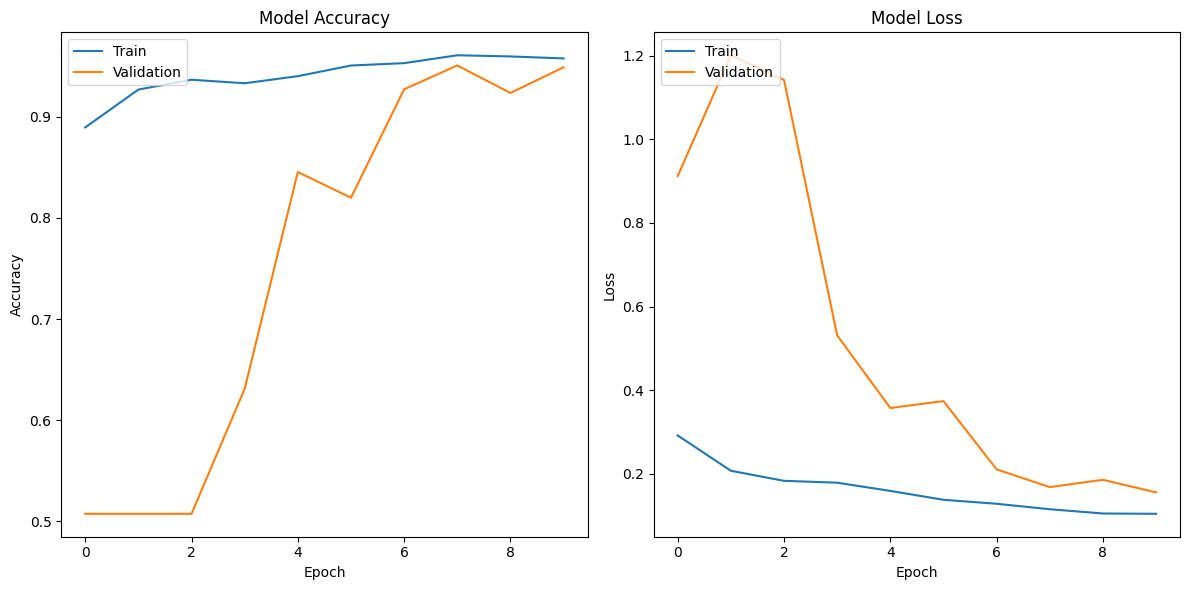

In [17]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


18/18 [==============================] - 1s 74ms/step


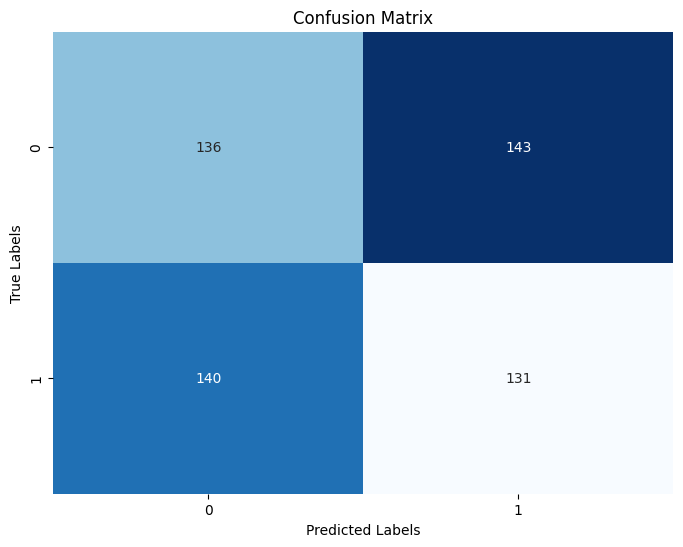

In [18]:
# Make predictions
predictions = model.predict(test_batches)
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print("Class indices:", train_batches.class_indices)

Class indices: {'DR': 0, 'No_DR': 1}


In [20]:
# Load the image you want to test
test_image_path = "/content/0083ee8054ee.png"
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)

# Preprocess the image
preprocessed_test_image = test_image_array / 255.0  # Normalize pixel values

# Use the trained model to make predictions
predictions = model.predict(preprocessed_test_image)
predicted_class_index = np.argmax(predictions)

# Reverse the class indices dictionary
class_labels = {v: k for k, v in train_batches.class_indices.items()}

# Get the predicted class label using the reversed dictionary
predicted_class = class_labels[predicted_class_index]

# Interpret the predictions
print("Predicted class:", predicted_class)
print("Predicted probabilities:", predictions)




NameError: name 'image' is not defined